# Q2. Repeat your experiment with MOM on a single-humped dataset but with Bayesian simulation using PyMC3 instead!

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')
import arviz as az

RANDOM_SEED = 20090425

In [2]:
fuel = pd.read_csv('/Users/asawari/Desktop/Fuel_Consumption_2000-2022.csv')
fuel = fuel.sample(frac=0.01, random_state=99)
fuel

,YEAR,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
8816,2009,SATURN,AURA HYBRID,MID-SIZE,2.4,4,A4,X,7.9,5.8,6.9,41,159
4310,2005,JAGUAR,X-TYPE SPORTWAGON,STATION WAGON - SMALL,2.5,6,M5,Z,12.2,7.9,10.3,27,237
17342,2017,NISSAN,FRONTIER,PICKUP TRUCK - SMALL,4.0,6,A5,X,14.8,10.6,12.9,22,304
13390,2014,CHEVROLET,CAMARO ZL1,COMPACT,6.2,8,AS6,Z,17.8,11.0,14.8,19,340
11333,2012,CHEVROLET,SONIC 5,SUBCOMPACT,1.8,4,M5,X,7.7,5.6,6.8,42,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11828,2012,MERCEDES-BENZ,S 63 AMG,FULL-SIZE,5.5,8,AS7,Z,13.8,9.1,11.6,24,267
20988,2021,Ford,GT,Two-seater,3.5,6,AM7,Z,19.8,12.8,16.6,17,393
8262,2009,FORD,EXPLORER SPORT TRAC,PICKUP TRUCK - STANDARD,4.0,6,A5,X,15.9,10.8,13.6,21,313
2685,2003,PORSCHE,911 CARRERA CABRIOLET,MINICOMPACT,3.6,6,M6,Z,13.1,8.2,10.9,26,251


In [3]:
fuel.isnull().sum()/len(fuel)

YEAR                0.0
MAKE                0.0
MODEL               0.0
VEHICLE CLASS       0.0
ENGINE SIZE         0.0
CYLINDERS           0.0
TRANSMISSION        0.0
FUEL                0.0
FUEL CONSUMPTION    0.0
HWY (L/100 km)      0.0
COMB (L/100 km)     0.0
COMB (mpg)          0.0
EMISSIONS           0.0
dtype: float64

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/Users/asawari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/asawari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with s

(-10.0, 10.0)

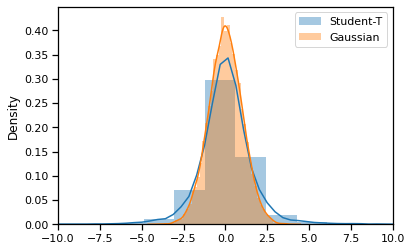

In [4]:
from pymc3 import StudentT, Normal

t = StudentT.dist(nu=3).random(size=10000)
n = Normal.dist(0,1).random(size=10000)

sns.distplot(t, label='Student-T')
sns.distplot(n, label='Gaussian')
plt.legend()
plt.xlim(-10,10)

Now, lets properly index the means and sd variables using the Emissions variable. I'm modeling data using a Student-T pdf model with 3 parameters and I model the first parameter using a normal distribution (pdf). As most of the values are centered around 300 s0 the Student-T priors for $\mu$ at 300 and standard deviation at 10

In [5]:
from pymc3 import Model, Uniform

with Model() as fuel_model:
    μ_0 = Normal('μ_0', 300, sd=10)
    μ_1 = Normal('μ_1', 300, sd=10)

I use a uniform distribution (pdf) to model the second parameter of the pdf-based model (standard deviation). Here, I have used upper bound as 650 and lower bound as 0

In [6]:
with fuel_model: 
    σ_0 = Uniform('σ_0', lower=0, upper=650)
    σ_1 = Uniform('σ_1', lower=0, upper=650)

For the degrees-of-freedom parameter
ν
 , use an exponential distribution with a mean of 250. I use an exponential distribution to model the third parameter of my student-T model.

/Users/asawari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


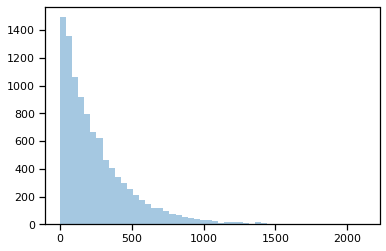

In [7]:
from pymc3 import Exponential
sns.distplot(Exponential.dist(1/250).random(size=10000), kde=False);

In [8]:
with fuel_model:
    ν = Exponential('ν_minus_one2', 1/300.) + 1

In [9]:
with fuel_model:
    fuel_like = StudentT('fuel_like2', nu=ν, mu=μ_1, lam=σ_1**2, observed=fuel['EMISSIONS'].values)

In [10]:
from pymc3 import Deterministic

with fuel_model:
    diff_of_means = Deterministic('difference of means1', μ_1 - μ_0)
    effect_size = Deterministic('effect size1', diff_of_means / np.sqrt((σ_1**2 + σ_0**2) / 2))

In [11]:
from pymc3 import fit

with fuel_model: 
    fuel_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Finished [100%]: Average Loss = 22,131


plotting all posterior distributions, throwing away the first 100 samples

Got error No model on context stack. trying to find log_likelihood in translation.


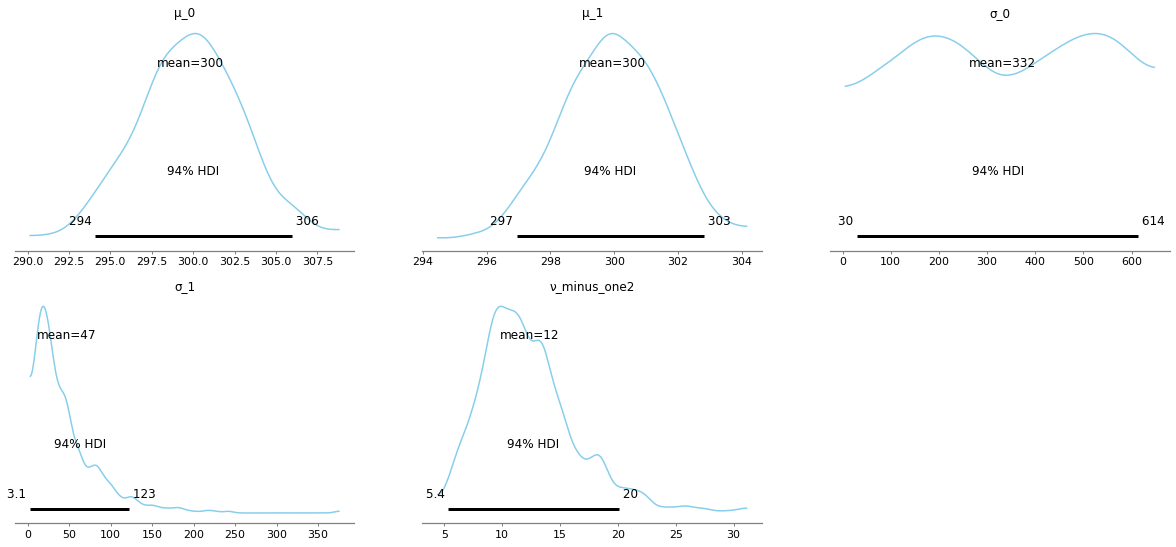

In [13]:
#from pymc3 import plot_posterior
from arviz import plot_posterior

plot_posterior(fuel_trace[100:], 
                var_names=['μ_0', 'μ_1', 'σ_0', 'σ_1', 'ν_minus_one2'],
                color='#87ceeb');


# Q3. Which method is more correct, and which was the most fun?

Both Maximum Likelihood Estimation (MLE) and Bayesian simulation using PyMC3 are valid methods for parameter estimation in statistical modeling, but they have different approaches and assumptions.

MLE is a method of finding the values of model parameters that maximize the likelihood of the observed data. It assumes that the data is generated by a fixed but unknown set of parameters and that the likelihood function is well-defined and differentiable. MLE is widely used and relatively easy to implement, but it doesn't provide any information about the uncertainty or variability of the estimated parameters.

On the other hand, Bayesian simulation using PyMC3 is a method that uses Bayesian inference to estimate the posterior distribution of the model parameters. It assumes that the model parameters are random variables with prior distributions and uses Bayes' theorem to update the prior distributions with the observed data to obtain the posterior distributions. Bayesian simulation provides not only point estimates of the parameters but also their uncertainty and variability, expressed as a posterior distribution.

In terms of which method is "more correct," it really depends on the specific problem and the assumptions that are appropriate for the data and the model being used. MLE may be preferred in cases where the model is well-defined and the assumptions of the likelihood function are appropriate, whereas Bayesian simulation may be preferred when prior information is available, or when uncertainty and variability in the estimates are important.

As for which method is more fun, that is subjective and depends on personal preferences. Some people may enjoy the simplicity and elegance of MLE, while others may enjoy the flexibility and richness of Bayesian simulation using PyMC3. Ultimately, both methods can be rewarding and provide valuable insights into statistical modeling and parameter estimation.